In [1]:
import pandas as pd
import numpy as np
import random
import os
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Datas

### 1.1 count data

In [4]:
animals = ["bird","cat","dog","fish","horse"]
for animal in animals:
    folder="Data_Scraping/Bilder/"+animal
    list = os.listdir(folder)
    number_files = len(list)
    print(animal, number_files)

bird 9785
cat 9961
dog 8123
fish 9403
horse 8940


### 1.2 show samples from data

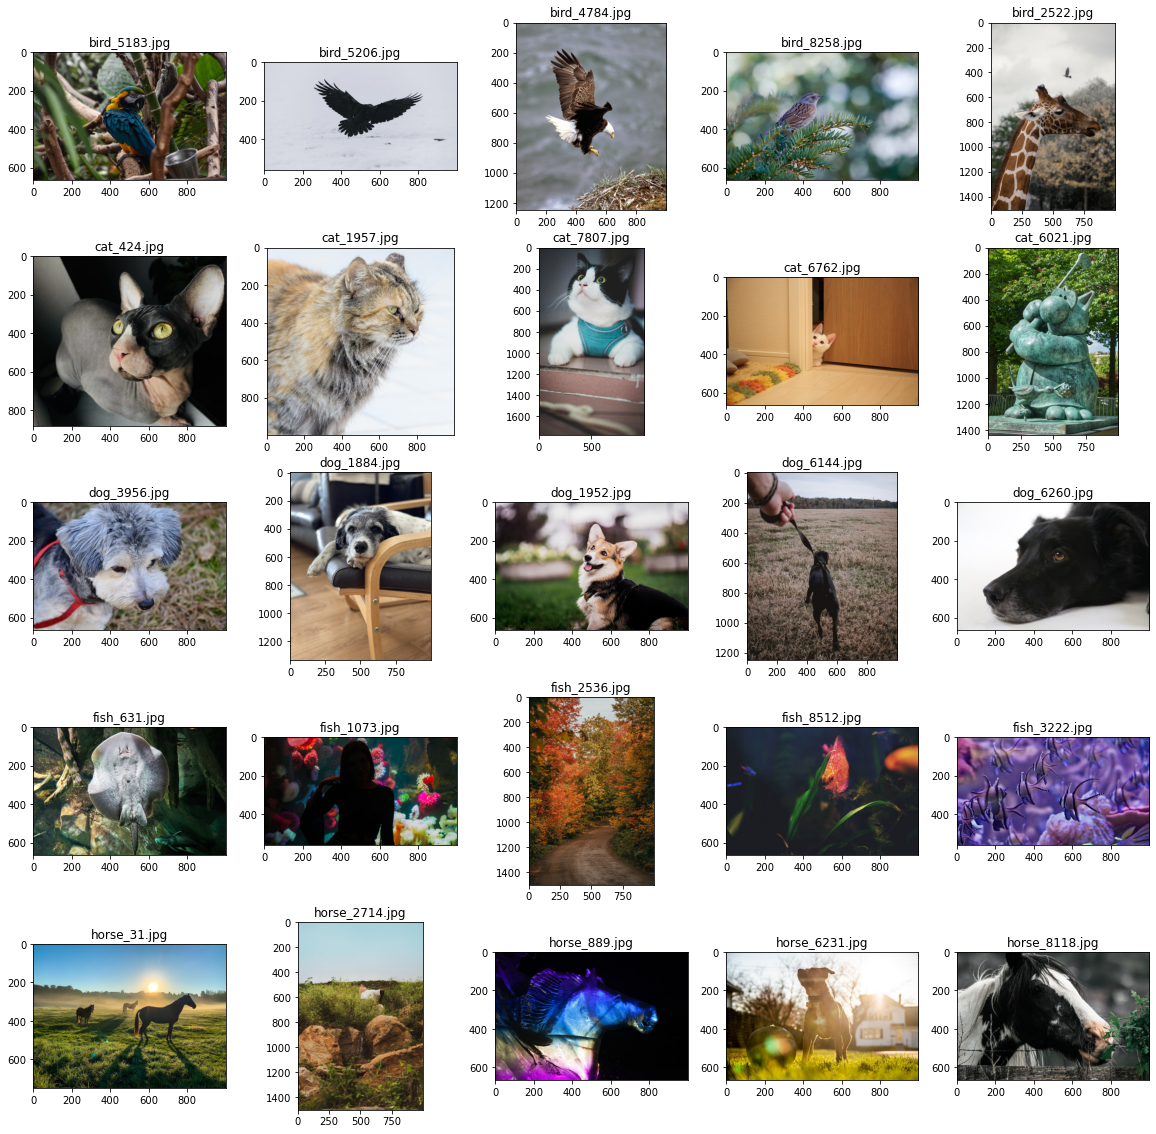

In [5]:
plt.figure(figsize=(20,20))
animals = ["bird","cat","dog","fish","horse"]
k = 0
for animal in animals:
    test_folder="Data_Scraping/Bilder/"+animal
    
    for i in range(5):
        file = random.choice(os.listdir(test_folder))
        image_path= os.path.join(test_folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(5,5,k+1)
        ax.title.set_text(file)
        plt.imshow(img)
        k = k+1    

### 1.3. split data in train and test

In [8]:
import splitfolders
input_folder = "Data_Scraping/Bilder/"
output = "Data_Scraping/train_test/" 

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2))

Copying files: 46212 files [00:40, 1144.37 files/s]


## 2. Load, resize and normalize data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
def image_loader(image_size=32, batch_size=4, root="Images/",num_workers=2,shuffle=False):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    data_set = torchvision.datasets.ImageFolder(root=root, transform=transform)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return data_loader

classes = ("bird","cat","dog","fish","horse")

In [6]:
train_path='Data_Scraping/train_test/train/'
test_path='Data_Scraping/train_test/test/'
batch_size = 4

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)


### 2.1 Visualize transformed images

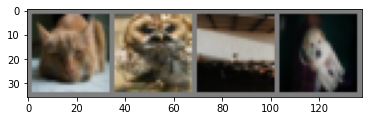

cat           bird           horse           dog


In [13]:
def images_show(img):
    img = img / 2 + 0.5
    numpy_img = img.numpy()
    plt.imshow(np.transpose(numpy_img, (1, 2, 0)))
    plt.show()

sample_data = iter(trainloader)
images, labels = sample_data.next()
images_show(torchvision.utils.make_grid(images))

print('           '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [18]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.684
[1,  4000] loss: 1.478
[1,  6000] loss: 1.439
[1,  8000] loss: 1.431
[2,  2000] loss: 1.405
[2,  4000] loss: 1.390
[2,  6000] loss: 1.388
[2,  8000] loss: 1.382
Finished Training


### save model

In [21]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### test model on data

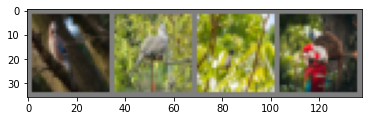

GroundTruth:   bird  bird  bird  bird


In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 43 %


In [26]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class bird  is: 53.5 %
Accuracy for class cat   is: 48.0 %
Accuracy for class dog   is: 8.2 %
Accuracy for class fish  is: 51.3 %
Accuracy for class horse is: 51.9 %
